# ASSIGNMENT TELKOM ATHON (MENTORING WEEK 7)
#### Nama: Rayvaldo Stefan Madika
#### NIK: 970044

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go
import plotly.express as px

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, homogeneity_score
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs

from scipy.cluster.hierarchy import dendrogram, linkage


import warnings
import os
warnings.filterwarnings("ignore")

py.offline.init_notebook_mode(connected = True)

In [2]:
df = pd.read_csv('data/Transactions.csv')
df.head()

,customer_id,trans_date,trans_amount
0,CS5295,11-Feb-18,35
1,CS4768,15-Mar-20,39
2,CS2122,26-Feb-18,52
3,CS1217,16-Nov-16,99
4,CS1850,20-Nov-18,78


In [3]:
df.shape

(125000, 3)

In [4]:
df.dtypes

customer_id     object
trans_date      object
trans_amount     int64
dtype: object

In [5]:
#cek jika ada missing value
df.isnull().sum(axis=0)

customer_id     0
trans_date      0
trans_amount    0
dtype: int64

In [6]:
#df['trans_date'] = pd.to_datetime(df['trans_date'])
#ada eror karena tanggal 29 Februari 2017 berada di luar range yang bisa diterima. perlu didrop atau diubah ke nilai lain.

In [7]:
#ubah data transaksi 29-Feb-17 ke 01-Mar-17 kemudian coba transform data trans_date kembali ke tipe datetime

In [8]:
df['trans_date'] = df['trans_date'].replace(['29-Feb-17'],'01-Mar-17')
df['trans_date'] = pd.to_datetime(df['trans_date'])
df.reset_index(inplace = True)

In [9]:
df.head()

,index,customer_id,trans_date,trans_amount
0,0,CS5295,2018-02-11,35
1,1,CS4768,2020-03-15,39
2,2,CS2122,2018-02-26,52
3,3,CS1217,2016-11-16,99
4,4,CS1850,2018-11-20,78


### RFM Analysis

In [10]:
#tentukan tanggal 6 Agustus 2021 sebagai tanggal pembanding recency
last_date = pd.datetime(2021,8,6)

In [11]:
rfm= df.groupby('customer_id').agg({'trans_date':lambda x: (last_date - x.max()), 'index': lambda x: len(x), 'trans_amount': lambda x: x.sum()})

#Rename column names to Recency, Frequency and Monetary
rfm.rename(columns={'trans_date': 'Recency', 
                         'index': 'Frequency', 
                         'trans_amount': 'Monetary'}, inplace=True)

rfm.reset_index().head()

,customer_id,Recency,Frequency,Monetary
0,CS1112,570 days,15,1012
1,CS1113,544 days,20,1490
2,CS1114,541 days,19,1432
3,CS1115,519 days,22,1659
4,CS1116,712 days,13,857


In [12]:
#Ubah type data di kolom Recency jadi int
rfm['Recency']=rfm['Recency'].dt.days.astype('int')

In [13]:
rfm.reset_index(inplace = True)
rfm.head()

,customer_id,Recency,Frequency,Monetary
0,CS1112,570,15,1012
1,CS1113,544,20,1490
2,CS1114,541,19,1432
3,CS1115,519,22,1659
4,CS1116,712,13,857


In [14]:
#Descriptive Statistics (Recency)
rfm.Recency.describe()

count    6889.000000
mean      589.349252
std        85.545443
min       508.000000
25%       531.000000
50%       562.000000
75%       620.000000
max      1366.000000
Name: Recency, dtype: float64

In [15]:
#Descriptive Statistics (Frequency)
rfm.Frequency.describe()

count    6889.000000
mean       18.144869
std         5.193014
min         4.000000
25%        14.000000
50%        18.000000
75%        22.000000
max        39.000000
Name: Frequency, dtype: float64

In [16]:
#Descriptive Statistics (Monetary)
rfm.Monetary.describe()

count    6889.000000
mean     1179.269705
std       465.832609
min       149.000000
25%       781.000000
50%      1227.000000
75%      1520.000000
max      2933.000000
Name: Monetary, dtype: float64

#### Distribution Plot

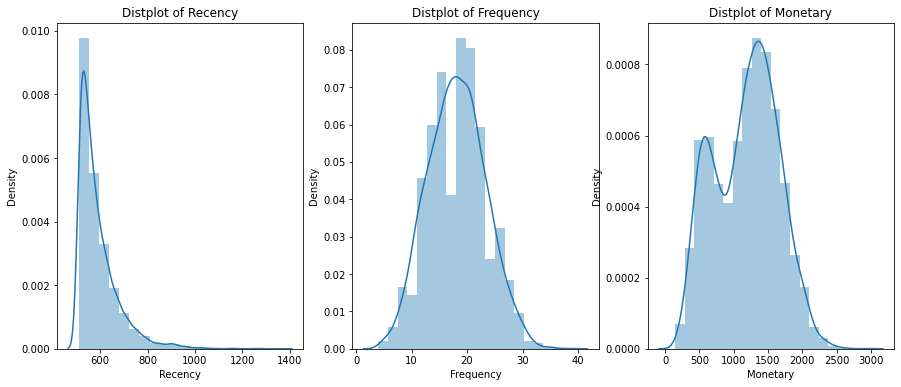

In [17]:
plt.figure(1 , figsize = (15 , 6))
n = 0 
for x in ['Recency' , 'Frequency' , 'Monetary']:
    n += 1
    plt.subplot(1 , 3 , n)
    sns.distplot(rfm[x] , bins = 20)
    plt.title('Distplot of {}'.format(x))
plt.show()

#### Recency Score

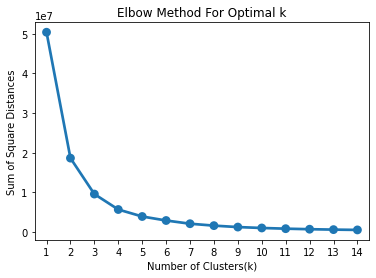

In [18]:
sum_of_sq_dist = {}
recency=rfm[['Recency']]
for k in range(1,15):
    km = KMeans(n_clusters= k, init= 'k-means++', max_iter= 1000)
    km = km.fit(recency)
    sum_of_sq_dist[k] = km.inertia_
    
#Plot the graph for the sum of square distance values and Number of Clusters
sns.pointplot(x = list(sum_of_sq_dist.keys()), y = list(sum_of_sq_dist.values()))
plt.xlabel('Number of Clusters(k)')
plt.ylabel('Sum of Square Distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [19]:
#Dari grafik cluster yang akan diambil adalah 4
rfm['R_cluster'] = KMeans(n_clusters=4).fit_predict(rfm[['Recency']])

In [20]:
rfm.groupby('R_cluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
R_cluster,,,,,,,,
0,3734.0,534.514194,17.712990,508.0,519.0,533.0,549.0,570.0
1,179.0,917.458101,98.153698,816.0,852.5,897.0,947.5,1366.0
2,2065.0,606.021308,24.487153,571.0,584.0,602.0,625.0,658.0
3,911.0,711.846323,41.147984,659.0,676.0,703.0,741.0,813.0


In [21]:
#Sekarang kita akan mengurutkan cluster berdasarkan ketidaktifan transaksinya berdasarkan mean dari cluster, di mana cluster 2
#merupakan cluster yang paling tidak aktif dengan mean tertinggi (917)

#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

rfm = order_cluster('R_cluster', 'Recency',rfm,False)

In [22]:
#Sekarang cluster telah terurut di mana cluster 0 memiliki ketidakaktifan terlama maupun sebaliknya, cluster 3 memiliki ketidakaktifan paling kecil
rfm.groupby('R_cluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
R_cluster,,,,,,,,
0,179.0,917.458101,98.153698,816.0,852.5,897.0,947.5,1366.0
1,911.0,711.846323,41.147984,659.0,676.0,703.0,741.0,813.0
2,2065.0,606.021308,24.487153,571.0,584.0,602.0,625.0,658.0
3,3734.0,534.514194,17.712990,508.0,519.0,533.0,549.0,570.0


#### Frequency Score

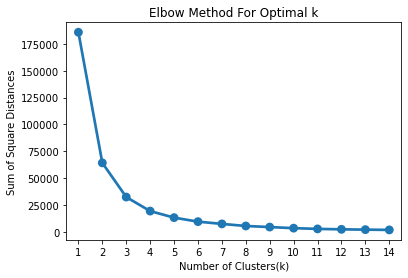

In [23]:
sum_of_sq_dist = {}
recency=rfm[['Frequency']]
for k in range(1,15):
    km = KMeans(n_clusters= k, init= 'k-means++', max_iter= 1000)
    km = km.fit(recency)
    sum_of_sq_dist[k] = km.inertia_
    
#Plot the graph for the sum of square distance values and Number of Clusters
sns.pointplot(x = list(sum_of_sq_dist.keys()), y = list(sum_of_sq_dist.values()))
plt.xlabel('Number of Clusters(k)')
plt.ylabel('Sum of Square Distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [24]:
#Dari grafik cluster yang akan diambil adalah 4
rfm['F_cluster'] = KMeans(n_clusters=4).fit_predict(rfm[['Frequency']])

#Urutkan cluster
rfm = order_cluster('F_cluster', 'Frequency',rfm,True)

In [25]:
rfm.groupby('F_cluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
F_cluster,,,,,,,,
0,1363.0,10.886280,1.994002,4.0,10.0,11.0,12.5,13.0
1,2284.0,16.154553,1.394320,14.0,15.0,16.0,17.0,18.0
2,2172.0,20.806169,1.368427,19.0,20.0,21.0,22.0,23.0
3,1070.0,26.237383,2.271494,24.0,24.0,26.0,27.0,39.0


#### Monetary Score

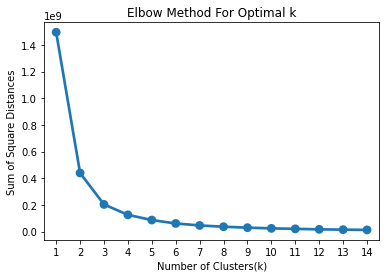

In [26]:
sum_of_sq_dist = {}
recency=rfm[['Monetary']]
for k in range(1,15):
    km = KMeans(n_clusters= k, init= 'k-means++', max_iter= 1000)
    km = km.fit(recency)
    sum_of_sq_dist[k] = km.inertia_
    
#Plot the graph for the sum of square distance values and Number of Clusters
sns.pointplot(x = list(sum_of_sq_dist.keys()), y = list(sum_of_sq_dist.values()))
plt.xlabel('Number of Clusters(k)')
plt.ylabel('Sum of Square Distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [27]:
#Dari grafik cluster yang akan diambil adalah 4
rfm['M_cluster'] = KMeans(n_clusters=4).fit_predict(rfm[['Monetary']])

#Urutkan cluster
rfm = order_cluster('M_cluster', 'Monetary',rfm,True)

In [28]:
rfm.groupby('M_cluster')['Monetary'].describe()

,count,mean,std,min,25%,50%,75%,max
M_cluster,,,,,,,,
0,1834.0,564.311887,145.522265,149.0,462.0,569.5,680.0,815.0
1,1750.0,1068.455429,123.363636,816.0,973.0,1082.5,1175.0,1254.0
2,2190.0,1440.217808,110.363338,1255.0,1345.0,1435.0,1531.0,1647.0
3,1115.0,1852.167713,173.547094,1648.0,1720.0,1807.0,1954.0,2933.0


### RFM Score

In [29]:
rfm.head()

,customer_id,Recency,Frequency,Monetary,R_cluster,F_cluster,M_cluster
0,CS1112,570,15,1012,3,1,1
1,CS1118,510,15,1011,3,1,1
2,CS1119,519,15,1158,3,1,1
3,CS1122,551,16,1156,3,1,1
4,CS1131,529,14,998,3,1,1


In [30]:
#Hitung nilai RFM Score
rfm['rfm_score'] = rfm['R_cluster'] + rfm['F_cluster'] + rfm['M_cluster']
rfm.groupby('rfm_score')['Recency','Frequency','Monetary'].mean()

,Recency,Frequency,Monetary
rfm_score,,,
0,939.416667,9.500000,451.712963
1,735.640411,10.756849,523.599315
2,649.947776,12.119923,594.185687
3,597.311618,13.090119,700.259501
4,587.569807,15.908059,948.830874
5,574.613333,17.309524,1158.019048
6,581.052752,20.003440,1366.776376
7,546.006045,21.292746,1488.721934
8,569.868132,25.041758,1779.714286


In [31]:
# Nilai 0 merupakan pelanggan dengan nilai RFM terburuk, dan nilai 9 merupakan pelanggan dengan nilai RFM terbaik
rfm['Customer_Segment'] = 'Silver'
rfm.loc[rfm['rfm_score']>3,'Customer_Segment'] = 'Gold' 
rfm.loc[rfm['rfm_score']>6,'Customer_Segment'] = 'Platinum' 

In [32]:
rfm.head()

,customer_id,Recency,Frequency,Monetary,R_cluster,F_cluster,M_cluster,rfm_score,Customer_Segment
0,CS1112,570,15,1012,3,1,1,5,Gold
1,CS1118,510,15,1011,3,1,1,5,Gold
2,CS1119,519,15,1158,3,1,1,5,Gold
3,CS1122,551,16,1156,3,1,1,5,Gold
4,CS1131,529,14,998,3,1,1,5,Gold


In [33]:
rfm.groupby('Customer_Segment').count()['rfm_score']

Customer_Segment
Gold        2803
Platinum    2248
Silver      1838
Name: rfm_score, dtype: int64

## Visualisasi dari Customer Segments

In [34]:
#Monetary vs Frequency
tx_graph = rfm.query("Monetary < 2000 and Frequency < 50")

plot_data = [
    go.Scatter(
        x=tx_graph.query("Customer_Segment == 'Silver'")['Frequency'],
        y=tx_graph.query("Customer_Segment == 'Silver'")['Monetary'],
        mode='markers',
        name='Silver',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'silver',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Customer_Segment == 'Gold'")['Frequency'],
        y=tx_graph.query("Customer_Segment == 'Gold'")['Monetary'],
        mode='markers',
        name='Gold',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'gold',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("Customer_Segment == 'Platinum'")['Frequency'],
        y=tx_graph.query("Customer_Segment == 'Platinum'")['Monetary'],
        mode='markers',
        name='Platinum',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Monetary"},
        xaxis= {'title': "Frequency"},
        title='Customer Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [35]:
#Frequency vs Recency
tx_graph = rfm.query("Frequency < 50 and Recency <1400")

plot_data = [
    go.Scatter(
        x=tx_graph.query("Customer_Segment == 'Silver'")['Recency'],
        y=tx_graph.query("Customer_Segment == 'Silver'")['Frequency'],
        mode='markers',
        name='Silver',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'silver',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Customer_Segment == 'Gold'")['Recency'],
        y=tx_graph.query("Customer_Segment == 'Gold'")['Frequency'],
        mode='markers',
        name='Gold',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'gold',
            opacity= 0.5
           )
    ),
        go.Scatter(
       x=tx_graph.query("Customer_Segment == 'Platinum'")['Recency'],
        y=tx_graph.query("Customer_Segment == 'Platinum'")['Frequency'],
        mode='markers',
        name='Platinum',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Frequency"},
        xaxis= {'title': "Recency"},
        title='Customer Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [36]:
#Monetary vs Recency
tx_graph = rfm.query("Monetary < 2000 and Recency <1400")

plot_data = [
    go.Scatter(
        x=tx_graph.query("Customer_Segment == 'Silver'")['Recency'],
        y=tx_graph.query("Customer_Segment == 'Silver'")['Monetary'],
        mode='markers',
        name='Silver',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'silver',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Customer_Segment == 'Gold'")['Recency'],
        y=tx_graph.query("Customer_Segment == 'Gold'")['Monetary'],
        mode='markers',
        name='Gold',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'gold',
            opacity= 0.5
           )
    ),
        go.Scatter(
       x=tx_graph.query("Customer_Segment == 'Platinum'")['Recency'],
        y=tx_graph.query("Customer_Segment == 'Platinum'")['Monetary'],
        mode='markers',
        name='Platinum',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Monetary"},
        xaxis= {'title': "Recency"},
        title='Customer Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [37]:
#3D Plot

fig = px.scatter_3d(rfm, x='Recency', y='Frequency', z='Monetary', color='Customer_Segment',opacity = 0.8, height=800)
fig.show()

## Conclusion

Setelah melakukan clustering menggunakan metode K-Means Clustering dan RFM analysis untuk menentukan clustering dari tiap
customer, diperoleh 3 kelompok segmen pelanggan, yaitu:

    -Platinum : Merupakan pelanggan dengan loyalitas tertinggi, memiliki frekuensi dan pengeluaran transaksi yang tinggi, 
                serta ketidakaktifan yang rendah. Terdapat 2247 pelanggan di cluster ini.
                
        -Gold : Merupakan pelanggan dengan loyalitas cukup tinggi, memiliki frekuensi dan pengeluaran transaksi yang 
                sedang/cukup tinggi, serta ketidakaktifan yang sedang. Terdapat 2803 pelanggan di cluster ini (terbanyak).
                
      -Silver : Merupakan pelanggan dengan loyalitas biasa, memiliki frekuensi dan pengeluaran transaksi yang cenderung
                rendah/sedang, serta ketidakaktifan yang cukup tinggi. Terdapat 1839 pelanggan di cluster ini (paling 
                sedikit).
                
Dari sini, dapat diberi masukan kepada tim marketing berdasarkan tiap segmen pelanggan:

    Platinum : Buat loyalty program
    
        Gold : Tawarkan add on untuk meningkatkan volume transaksi
        
       Silver: Buat program retensi dan tawarkan gimmick/bundling untuk meningkatkan volume transaksi